In [ ]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install arabic-reshaper
!pip install python-bidi

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import requests
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [3]:
# Download the dataset
url = 'https://raw.githubusercontent.com/SamirMoustafa/nmt-with-attention-for-ar-to-en/master/ara_.txt'
response = requests.get(url)

# Save the data to a temporary file
with open('ara_.txt', 'wb') as f:
    f.write(response.content)

# Read the dataset
with open('ara_.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

In [4]:
# Preprocess the data and assign labels
english_sentences = []
arabic_sentences = []

for line in lines:
    parts = line.strip().split('\t')
    english_sentences.append(parts[0])
    arabic_sentences.append(parts[1])

# Assign labels
english_labels = ['English'] * len(english_sentences)
arabic_labels = ['Arabic'] * len(arabic_sentences)

# Combine English and Arabic data
data = pd.DataFrame({'english': english_sentences + arabic_sentences,
                     'arabic': arabic_sentences + english_sentences,
                     'label': english_labels + arabic_labels})

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Tokenize English sentences
tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(data['english'])
train_en_seq = tokenizer_en.texts_to_sequences(data['english'])

# Tokenize Arabic sentences
tokenizer_ar = Tokenizer()
tokenizer_ar.fit_on_texts(data['arabic'])
train_ar_seq = tokenizer_ar.texts_to_sequences(data['arabic'])

# Pad sequences to ensure uniform length
max_seq_length = 20
train_en_pad = pad_sequences(train_en_seq, maxlen=max_seq_length, padding='post')
train_ar_pad = pad_sequences(train_ar_seq, maxlen=max_seq_length, padding='post')

# Convert labels to numerical values
train_labels = (data['label'] == 'English').astype(int)

In [5]:
# Define Siamese Network
def siamese_model(input_shape):
    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    # Base network
    base_network = tf.keras.Sequential([
        layers.Embedding(input_dim=num_words, output_dim=100, input_length=max_seq_length),
        layers.LSTM(100, return_sequences=True),
        layers.LSTM(100),
        layers.Dense(100, activation='relu')
    ])

    # Process the inputs through the base network
    processed_1 = base_network(input_1)
    processed_2 = base_network(input_2)

    # Calculate L1 distance between the processed vectors
    distance = tf.abs(tf.subtract(processed_1, processed_2))

    # Output layer
    output = layers.Dense(1, activation='sigmoid')(distance)

    model = Model(inputs=[input_1, input_2], outputs=output)

    return model

In [6]:
# Prepare dataset
num_samples = len(train_en_pad)  # Adjust this accordingly
num_words = 10000  # Adjust this based on your data

# Split the data into 80% training and 20% test
train_en, test_en, train_ar, test_ar, train_labels, test_labels = train_test_split(train_en_pad, train_ar_pad, train_labels, test_size=0.2, random_state=42)

In [7]:
# Train the Siamese Network
input_shape = (max_seq_length,)
model = siamese_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit([train_en, train_ar], train_labels, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
484/484 [==============================] - 35s 42ms/step - loss: 0.5850 - accuracy: 0.6313 - val_loss: 0.3486 - val_accuracy: 0.8226
Epoch 2/10
484/484 [==============================] - 7s 15ms/step - loss: 0.2588 - accuracy: 0.8805 - val_loss: 0.2292 - val_accuracy: 0.8871
Epoch 3/10
484/484 [==============================] - 6s 12ms/step - loss: 0.1433 - accuracy: 0.9397 - val_loss: 0.2140 - val_accuracy: 0.9040
Epoch 4/10
484/484 [==============================] - 7s 14ms/step - loss: 0.0864 - accuracy: 0.9668 - val_loss: 0.2387 - val_accuracy: 0.9122
Epoch 5/10
484/484 [==============================] - 5s 11ms/step - loss: 0.0597 - accuracy: 0.9753 - val_loss: 0.2687 - val_accuracy: 0.9110
Epoch 6/10
484/484 [==============================] - 7s 15ms/step - loss: 0.0534 - accuracy: 0.9805 - val_loss: 0.2493 - val_accuracy: 0.9133
Epoch 7/10
484/484 [==============================] - 10s 20ms/step - loss: 0.0423 - accuracy: 0.9856 - val_loss: 0.3036 - val_accuracy: 0.91

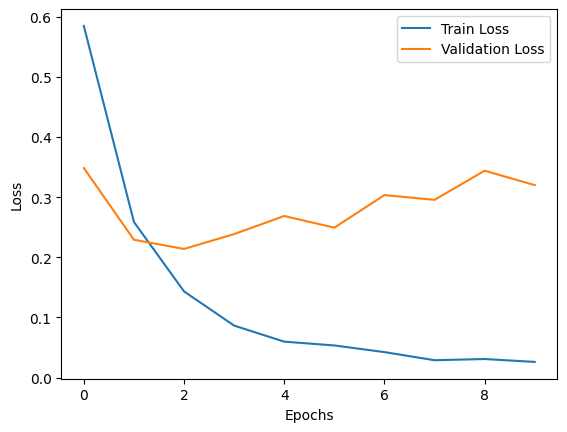

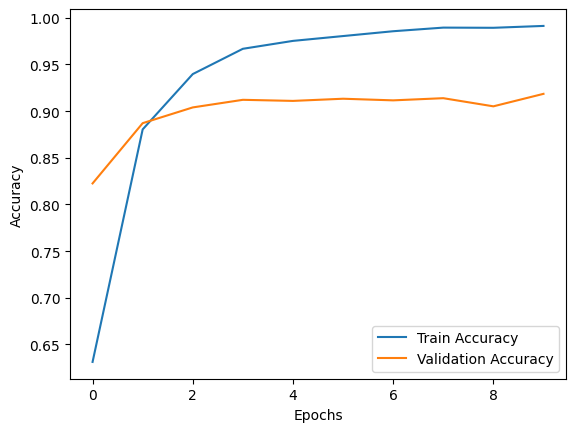

538/538 [==============================] - 3s 5ms/step - loss: 0.0431 - accuracy: 0.9883
Final Train Loss: 0.043146368116140366
Final Train Accuracy: 98.83050918579102 %
135/135 [==============================] - 1s 5ms/step - loss: 0.3847 - accuracy: 0.9023
Test Loss: 0.3846551179885864
Test Accuracy: 90.22573828697205 %


In [21]:
# Plotting training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Print final train loss and accuracy
train_loss, train_accuracy = model.evaluate([train_en, train_ar], train_labels)
print("Final Train Loss:", train_loss)
print("Final Train Accuracy:", train_accuracy*100,"%")

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate([test_en, test_ar], test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy*100,"%")

In [11]:
def preprocess_sentence(sentence, max_seq_length):
    words = sentence.split()
    if len(words) > max_seq_length:
        words = words[:max_seq_length]
    else:
        words += [''] * (max_seq_length - len(words))
    return words

def compute_similarity(sentence1, sentence2, model, tokenizer_en, tokenizer_ar, max_seq_length):
    processed_sentence1 = preprocess_sentence(sentence1, max_seq_length)
    processed_sentence2 = preprocess_sentence(sentence2, max_seq_length)

    # Tokenize and pad the sequences
    input_en = pad_sequences(tokenizer_en.texts_to_sequences([processed_sentence1]), maxlen=max_seq_length, padding='post')
    input_ar = pad_sequences(tokenizer_ar.texts_to_sequences([processed_sentence2]), maxlen=max_seq_length, padding='post')

    similarity_score = model.predict([input_en, input_ar])[0][0]

    return similarity_score

In [26]:
# Example usage
user_sentence1 = "Why Me "
user_sentence2 = "لماذا أنا "

similarity_score = compute_similarity(user_sentence1, user_sentence2, model, tokenizer_en, tokenizer_ar, max_seq_length)
print("Similarity Score:", similarity_score*100)

1/1 [==============================] - 0s 32ms/step
Similarity Score: 79.81667518615723


In [25]:
# Example usage
user_sentence1 = "Programming Is Fun "
user_sentence2 = "البرمجه ممتعه "

similarity_score = compute_similarity(user_sentence1, user_sentence2, model, tokenizer_en, tokenizer_ar, max_seq_length)
print("Similarity Score:", similarity_score*100)

1/1 [==============================] - 0s 20ms/step
Similarity Score: 99.89726543426514


In [33]:
# Example usage
user_sentence1 = "Is the cat on the chair or under the chair?"
user_sentence2 = "هل القطة فوق الكرسي أم أسفله ؟"

similarity_score = compute_similarity(user_sentence1, user_sentence2, model, tokenizer_en, tokenizer_ar, max_seq_length)
print("Similarity Score:", similarity_score*100)

1/1 [==============================] - 0s 20ms/step
Similarity Score: 100.0


In [38]:
# Example usage
user_sentence1 = "I Like Pizza"
user_sentence2 = "انا تعجبني البيتزا"

similarity_score = compute_similarity(user_sentence1, user_sentence2, model, tokenizer_en, tokenizer_ar, max_seq_length)
print("Similarity Score:", similarity_score*100)

1/1 [==============================] - 0s 20ms/step
Similarity Score: 99.98444318771362


In [41]:
# Example usage
user_sentence1 = "Of course"
user_sentence2 = "طبعا"

similarity_score = compute_similarity(user_sentence1, user_sentence2, model, tokenizer_en, tokenizer_ar, max_seq_length)
print("Similarity Score:", similarity_score*100)

1/1 [==============================] - 0s 20ms/step
Similarity Score: 99.74700212478638


In [42]:
# Example usage
user_sentence1 = "Of course"
user_sentence2 = "بالطبع"

similarity_score = compute_similarity(user_sentence1, user_sentence2, model, tokenizer_en, tokenizer_ar, max_seq_length)
print("Similarity Score:", similarity_score*100)

1/1 [==============================] - 0s 20ms/step
Similarity Score: 99.98242259025574
